<a href="https://colab.research.google.com/github/marianavalho/ML2025/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2 Maria Navalho


Cross-validated RMSE scores: [0.45051331 1.00198687 0.69028805 2.68534845 0.65721383]
Mean RMSE: 1.097070100683442
RMSE on full data: 1.3364633051943289
R² Score on full data: 0.7835193458359989


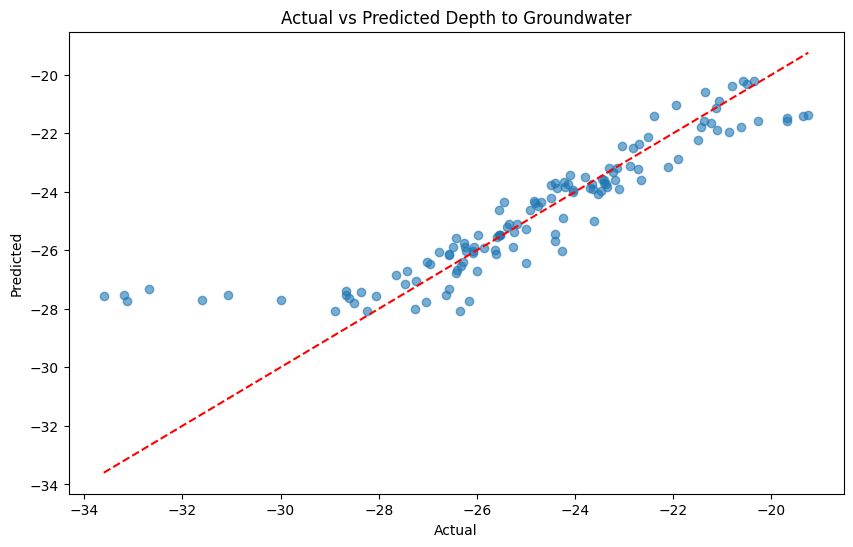

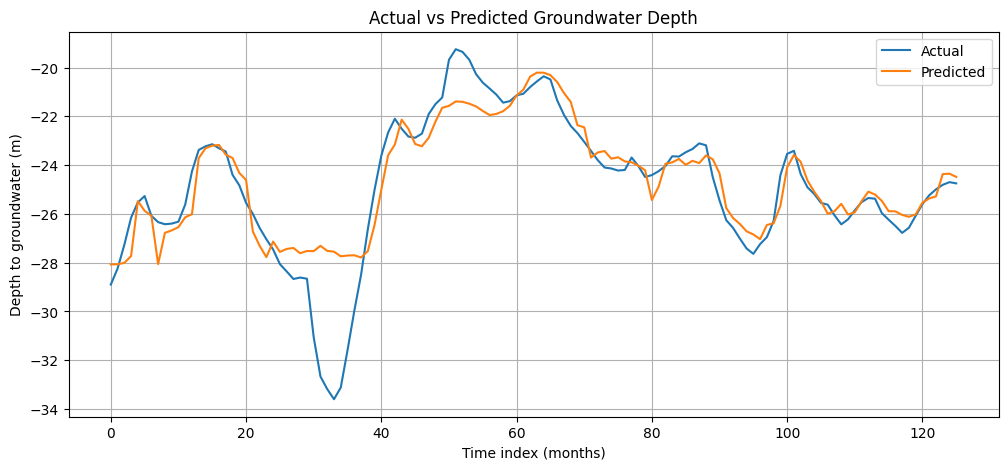

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['date'])

    df['year_month'] = df['date'].dt.to_period('M')
    monthly = df.groupby('year_month').median(numeric_only=True)  # Aggregate by median monthly data
    monthly.index = monthly.index.to_timestamp()

    monthly = monthly[monthly.index >= '2009-01-01']
    monthly.dropna(inplace=True)

    return monthly

def create_lagged_features(monthly):
    features = ['rainfall_mm', 'temperature_C', 'drainage_m3', 'river_hydrometry_m', 'depth_to_groundwater_m']
    for lag in range(1, 13):
        for feature in features:
            monthly[f'{feature}_lag{lag}'] = monthly[feature].shift(lag)

    monthly['target'] = monthly['depth_to_groundwater_m']
    monthly.drop(columns=['depth_to_groundwater_m'], inplace=True)
    monthly.dropna(inplace=True)

    return monthly

def train_and_evaluate_model(X, y, monthly):
    group_kfold = GroupKFold(n_splits=5)
    groups = monthly.index.year  # Using the year as the grouping variable for cross-validation

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    cv_scores = cross_val_score(pipeline, X, y, cv=group_kfold, scoring='neg_root_mean_squared_error', groups=groups)
    print(f'Cross-validated RMSE scores: {-cv_scores}')

    mean_rmse = -cv_scores.mean()
    print(f'Mean RMSE: {mean_rmse}')

    y_pred = cross_val_predict(pipeline, X, y, cv=group_kfold, groups=groups)

    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    print(f'RMSE on full data: {rmse}')
    print(f'R² Score on full data: {r2}')

    # Plot Actual vs Predicted:
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.6)
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Depth to Groundwater')
    plt.show()

    # Plot of time series:
    plt.figure(figsize=(12, 5))
    plt.plot(y.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title("Actual vs Predicted Groundwater Depth")
    plt.xlabel("Time index (months)")
    plt.ylabel("Depth to groundwater (m)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pipeline, X, y

def main(file_path):
    monthly = load_and_preprocess_data(file_path)

    monthly = create_lagged_features(monthly)

    X = monthly.drop(columns='target')
    y = monthly['target']
    pipeline, X, y = train_and_evaluate_model(X, y, monthly)

if __name__ == "__main__":
    file_path = "/content/aquifer_time_series.csv" # Having imported the file to colab
    main(file_path)